In [ ]:
import pandas
import numpy
import zipfile

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download PlantVillage dataset
!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 654M/658M [00:01<00:00, 270MB/s]
100% 658M/658M [00:01<00:00, 385MB/s]


In [ ]:
!unzip plantdisease.zip -d plant_disease_dataset


Streaming output truncated to the last 5000 lines.
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_disease_dataset/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf__

In [ ]:
import os

base_dir = "/content/plant_disease_dataset"
print("Folders (classes) inside dataset:")
print(os.listdir(base_dir)[:10])  # show first 10 class folders


Folders (classes) inside dataset:
['plantvillage', 'PlantVillage']


In [ ]:
import os

root = "/content/plant_disease_dataset"  # adjust if needed

for dirpath, dirnames, filenames in os.walk(root):
    level = dirpath.replace(root, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(dirpath)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in filenames[:3]:  # show only first 3 files per folder for clarity
        print(f"{subindent}{f}")


plant_disease_dataset/
    plantvillage/
        PlantVillage/
            Potato___healthy/
                5df30492-0b54-474d-8883-bba9474ca88f___RS_HL 1801.JPG
                5fcbde8f-52af-4963-b324-ff7f4dd6bd4c___RS_HL 1762.JPG
                3edf7c3f-73e0-439c-870d-76cfd7c3bc45___RS_HL 1859.JPG
            Potato___Late_blight/
                b294595b-8950-4e5b-8dfc-2ad9ca2c5e0a___RS_LB 4475.JPG
                2a52ba17-febc-49b9-b5ab-52a500d387de___RS_LB 2621.JPG
                80bdc2a3-66b8-4d95-abe7-65c7806f7cbf___RS_LB 3073.JPG
            Tomato__Tomato_YellowLeaf__Curl_Virus/
                3167dea8-47ef-4761-9e14-f7b66dcd976f___YLCV_NREC 2538.JPG
                07814785-df21-4b4c-9e52-b43131eaaa76___UF.GRC_YLCV_Lab 09327.JPG
                594aa195-6f0d-4a40-9fa9-3ed0121cec94___UF.GRC_YLCV_Lab 01891.JPG
            Tomato_Bacterial_spot/
                1169b92d-a606-4560-ae1a-ceee401fc959___GCREC_Bact.Sp 3447.JPG
                6c60e843-43e5-4983-a406-a77b82d294e2_

In [ ]:
!rm -rf /content/plant_disease_dataset/plantvillage


In [ ]:
import os
print(os.listdir(base_dir))
print(f"Total classes: {len(os.listdir(base_dir))}")


['PlantVillage']
Total classes: 1


In [ ]:
import os
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import shutil
import matplotlib.pyplot as plt
import numpy as np

# ========================
# STEP 1: Paths and Split
# ========================
base_dir = "/content/plant_disease_dataset/PlantVillage"
train_dir = "/content/plant_disease_dataset/train"
val_dir = "/content/plant_disease_dataset/val"
test_dir = "/content/plant_disease_dataset/test"

for path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(path):
        os.makedirs(path)

# Split each class into train/val/test
for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if os.path.isdir(cls_path):
        images = os.listdir(cls_path)
        train_files, temp = train_test_split(images, test_size=0.2, random_state=42)
        val_files, test_files = train_test_split(temp, test_size=0.5, random_state=42)

        # Helper function to copy files
        def copy_files(files, dest_dir):
            dest_cls_dir = os.path.join(dest_dir, cls)
            os.makedirs(dest_cls_dir, exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(cls_path, f), os.path.join(dest_cls_dir, f))

        copy_files(train_files, train_dir)
        copy_files(val_files, val_dir)
        copy_files(test_files, test_dir)

print("✅ Dataset split into train/val/test successfully!")

# ========================
# STEP 2: Transforms
# ========================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========================
# STEP 3: Data Loaders
# ========================
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")
print(f"Classes: {train_data.classes}")


✅ Dataset split into train/val/test successfully!
Train: 16504 | Val: 2064 | Test: 2070
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


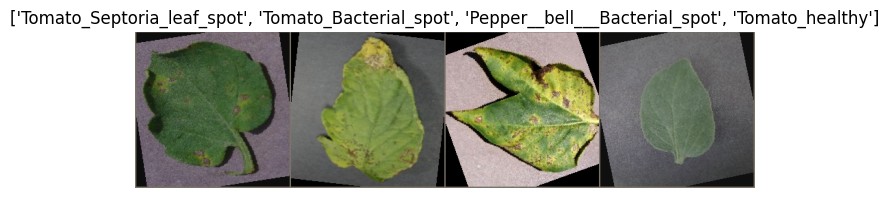

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    # Unnormalize properly (undo mean/std normalization)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean  # reverse normalization
    img = torch.clamp(img, 0, 1)  # keep pixel values in [0,1]

    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Display again
dataiter = iter(train_loader)
images, labels = next(dataiter)
grid = torchvision.utils.make_grid(images[:4])
imshow(grid, title=[train_data.classes[i] for i in labels[:4]])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ==============================
# 1️⃣ Device setup
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==============================
# 2️⃣ Load Pretrained ResNet50
# ==============================
from torchvision.models import ResNet50_Weights

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Freeze all layers except final ones
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer
num_classes = len(train_data.classes)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# ==============================
# 3️⃣ Loss & Optimizer
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)

# ==============================
# 4️⃣ Training with Metrics
# ==============================
epochs = 25
best_acc = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("-" * 40)

    # --- Training phase ---
    model.train()
    train_loss, all_preds, all_labels = 0.0, [], []

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_loss /= len(train_loader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    train_rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    train_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    # --- Validation phase ---
    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_prec = precision_score(val_labels, val_preds, average='macro', zero_division=0)
    val_rec = recall_score(val_labels, val_preds, average='macro', zero_division=0)
    val_f1 = f1_score(val_labels, val_preds, average='macro', zero_division=0)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Train Precision: {train_prec:.4f} | Val Precision: {val_prec:.4f}")
    print(f"Train Recall: {train_rec:.4f} | Val Recall: {val_rec:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")

    # --- Save Best Model ---
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_plant_disease_model.pt")
        print("✅ Best model updated!")

print(f"\n🎯 Training complete! Best Validation Accuracy: {best_acc:.4f}")


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]



Epoch 1/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 1.4993 | Val Loss: 0.8670
Train Acc: 0.6116 | Val Acc: 0.8154
Train Precision: 0.5835 | Val Precision: 0.7843
Train Recall: 0.4828 | Val Recall: 0.6988
Train F1: 0.4933 | Val F1: 0.6977
✅ Best model updated!

Epoch 2/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.6815 | Val Loss: 0.5282
Train Acc: 0.8226 | Val Acc: 0.8784
Train Precision: 0.8338 | Val Precision: 0.8903
Train Recall: 0.7294 | Val Recall: 0.8275
Train F1: 0.7445 | Val F1: 0.8472
✅ Best model updated!

Epoch 3/25
----------------------------------------


100%|██████████| 516/516 [02:06<00:00,  4.09it/s]


Train Loss: 0.4823 | Val Loss: 0.4047
Train Acc: 0.8692 | Val Acc: 0.8987
Train Precision: 0.8708 | Val Precision: 0.9085
Train Recall: 0.8187 | Val Recall: 0.8686
Train F1: 0.8372 | Val F1: 0.8833
✅ Best model updated!

Epoch 4/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.3874 | Val Loss: 0.3046
Train Acc: 0.8926 | Val Acc: 0.9172
Train Precision: 0.8943 | Val Precision: 0.9182
Train Recall: 0.8609 | Val Recall: 0.8982
Train F1: 0.8746 | Val F1: 0.9061
✅ Best model updated!

Epoch 5/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.3316 | Val Loss: 0.2640
Train Acc: 0.9051 | Val Acc: 0.9317
Train Precision: 0.8992 | Val Precision: 0.9275
Train Recall: 0.8778 | Val Recall: 0.9151
Train F1: 0.8873 | Val F1: 0.9197
✅ Best model updated!

Epoch 6/25
----------------------------------------


100%|██████████| 516/516 [02:06<00:00,  4.08it/s]


Train Loss: 0.2922 | Val Loss: 0.2399
Train Acc: 0.9154 | Val Acc: 0.9293
Train Precision: 0.9123 | Val Precision: 0.9244
Train Recall: 0.8932 | Val Recall: 0.9160
Train F1: 0.9018 | Val F1: 0.9185

Epoch 7/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.11it/s]


Train Loss: 0.2698 | Val Loss: 0.2153
Train Acc: 0.9212 | Val Acc: 0.9419
Train Precision: 0.9167 | Val Precision: 0.9392
Train Recall: 0.9048 | Val Recall: 0.9266
Train F1: 0.9104 | Val F1: 0.9320
✅ Best model updated!

Epoch 8/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.2450 | Val Loss: 0.1936
Train Acc: 0.9274 | Val Acc: 0.9472
Train Precision: 0.9223 | Val Precision: 0.9414
Train Recall: 0.9121 | Val Recall: 0.9355
Train F1: 0.9168 | Val F1: 0.9381
✅ Best model updated!

Epoch 9/25
----------------------------------------


100%|██████████| 516/516 [02:06<00:00,  4.09it/s]


Train Loss: 0.2333 | Val Loss: 0.1783
Train Acc: 0.9289 | Val Acc: 0.9486
Train Precision: 0.9233 | Val Precision: 0.9473
Train Recall: 0.9119 | Val Recall: 0.9402
Train F1: 0.9172 | Val F1: 0.9435
✅ Best model updated!

Epoch 10/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.11it/s]


Train Loss: 0.2180 | Val Loss: 0.1720
Train Acc: 0.9333 | Val Acc: 0.9501
Train Precision: 0.9306 | Val Precision: 0.9490
Train Recall: 0.9196 | Val Recall: 0.9402
Train F1: 0.9246 | Val F1: 0.9440
✅ Best model updated!

Epoch 11/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.2062 | Val Loss: 0.1685
Train Acc: 0.9392 | Val Acc: 0.9501
Train Precision: 0.9357 | Val Precision: 0.9519
Train Recall: 0.9276 | Val Recall: 0.9345
Train F1: 0.9314 | Val F1: 0.9420

Epoch 12/25
----------------------------------------


100%|██████████| 516/516 [02:06<00:00,  4.09it/s]


Train Loss: 0.1939 | Val Loss: 0.1637
Train Acc: 0.9404 | Val Acc: 0.9491
Train Precision: 0.9368 | Val Precision: 0.9484
Train Recall: 0.9307 | Val Recall: 0.9399
Train F1: 0.9336 | Val F1: 0.9438

Epoch 13/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.11it/s]


Train Loss: 0.1925 | Val Loss: 0.1556
Train Acc: 0.9397 | Val Acc: 0.9535
Train Precision: 0.9353 | Val Precision: 0.9551
Train Recall: 0.9281 | Val Recall: 0.9418
Train F1: 0.9315 | Val F1: 0.9473
✅ Best model updated!

Epoch 14/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.12it/s]


Train Loss: 0.1812 | Val Loss: 0.1481
Train Acc: 0.9437 | Val Acc: 0.9549
Train Precision: 0.9408 | Val Precision: 0.9530
Train Recall: 0.9349 | Val Recall: 0.9451
Train F1: 0.9378 | Val F1: 0.9487
✅ Best model updated!

Epoch 15/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.1699 | Val Loss: 0.1433
Train Acc: 0.9461 | Val Acc: 0.9569
Train Precision: 0.9431 | Val Precision: 0.9524
Train Recall: 0.9384 | Val Recall: 0.9503
Train F1: 0.9406 | Val F1: 0.9511
✅ Best model updated!

Epoch 16/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.12it/s]


Train Loss: 0.1678 | Val Loss: 0.1417
Train Acc: 0.9478 | Val Acc: 0.9545
Train Precision: 0.9449 | Val Precision: 0.9534
Train Recall: 0.9401 | Val Recall: 0.9439
Train F1: 0.9423 | Val F1: 0.9482

Epoch 17/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.12it/s]


Train Loss: 0.1583 | Val Loss: 0.1337
Train Acc: 0.9498 | Val Acc: 0.9530
Train Precision: 0.9469 | Val Precision: 0.9512
Train Recall: 0.9427 | Val Recall: 0.9433
Train F1: 0.9448 | Val F1: 0.9470

Epoch 18/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.11it/s]


Train Loss: 0.1516 | Val Loss: 0.1351
Train Acc: 0.9510 | Val Acc: 0.9564
Train Precision: 0.9474 | Val Precision: 0.9543
Train Recall: 0.9436 | Val Recall: 0.9473
Train F1: 0.9454 | Val F1: 0.9504

Epoch 19/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.1562 | Val Loss: 0.1288
Train Acc: 0.9486 | Val Acc: 0.9530
Train Precision: 0.9461 | Val Precision: 0.9526
Train Recall: 0.9424 | Val Recall: 0.9439
Train F1: 0.9442 | Val F1: 0.9478

Epoch 20/25
----------------------------------------


100%|██████████| 516/516 [02:06<00:00,  4.08it/s]


Train Loss: 0.1506 | Val Loss: 0.1265
Train Acc: 0.9517 | Val Acc: 0.9549
Train Precision: 0.9484 | Val Precision: 0.9546
Train Recall: 0.9446 | Val Recall: 0.9450
Train F1: 0.9464 | Val F1: 0.9495

Epoch 21/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.1393 | Val Loss: 0.1289
Train Acc: 0.9549 | Val Acc: 0.9569
Train Precision: 0.9519 | Val Precision: 0.9551
Train Recall: 0.9482 | Val Recall: 0.9423
Train F1: 0.9500 | Val F1: 0.9482

Epoch 22/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.11it/s]


Train Loss: 0.1371 | Val Loss: 0.1241
Train Acc: 0.9548 | Val Acc: 0.9540
Train Precision: 0.9516 | Val Precision: 0.9515
Train Recall: 0.9503 | Val Recall: 0.9445
Train F1: 0.9509 | Val F1: 0.9476

Epoch 23/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.12it/s]


Train Loss: 0.1373 | Val Loss: 0.1238
Train Acc: 0.9569 | Val Acc: 0.9559
Train Precision: 0.9546 | Val Precision: 0.9544
Train Recall: 0.9506 | Val Recall: 0.9450
Train F1: 0.9526 | Val F1: 0.9493

Epoch 24/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.1348 | Val Loss: 0.1212
Train Acc: 0.9571 | Val Acc: 0.9603
Train Precision: 0.9552 | Val Precision: 0.9564
Train Recall: 0.9521 | Val Recall: 0.9521
Train F1: 0.9536 | Val F1: 0.9540
✅ Best model updated!

Epoch 25/25
----------------------------------------


100%|██████████| 516/516 [02:05<00:00,  4.10it/s]


Train Loss: 0.1367 | Val Loss: 0.1182
Train Acc: 0.9554 | Val Acc: 0.9569
Train Precision: 0.9531 | Val Precision: 0.9540
Train Recall: 0.9501 | Val Recall: 0.9471
Train F1: 0.9515 | Val F1: 0.9502

🎯 Training complete! Best Validation Accuracy: 0.9603



📊 Test Results:
Test Loss: 0.1237
Accuracy: 0.9594
Precision: 0.9566
Recall: 0.9527
F1 Score: 0.9539


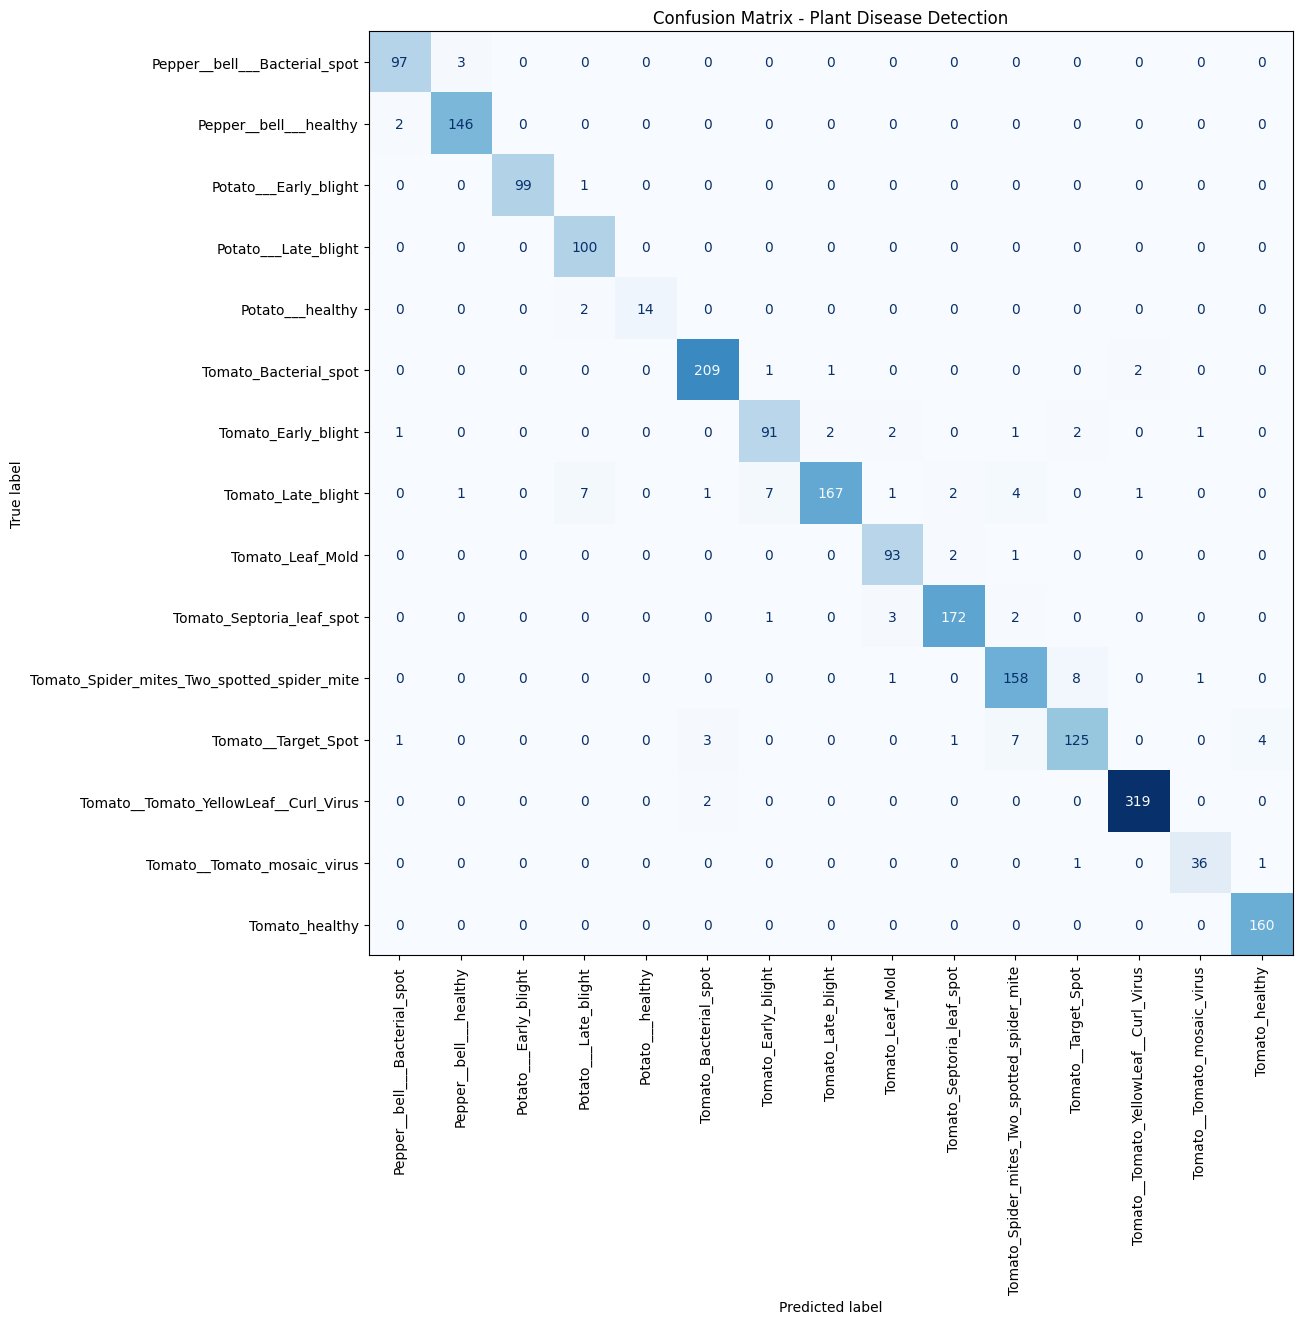

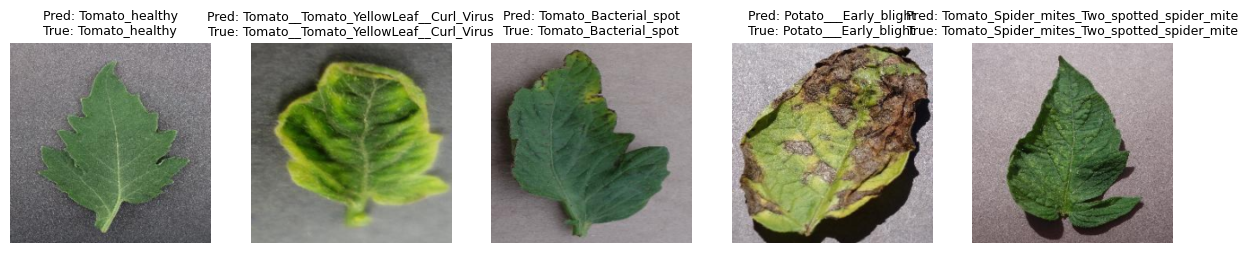

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import random

# ==============================
# 1️⃣ Load best model
# ==============================
model.load_state_dict(torch.load("best_plant_disease_model.pt", map_location=device))
model.eval()

# ==============================
# 2️⃣ Evaluate on Test Set
# ==============================
all_preds, all_labels = [], []
criterion = nn.CrossEntropyLoss()
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"\n📊 Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# ==============================
# 3️⃣ Confusion Matrix
# ==============================
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues', colorbar=False, xticks_rotation=90)
plt.title("Confusion Matrix - Plant Disease Detection")
plt.show()

# ==============================
# 4️⃣ Random Predictions Visualization
# ==============================
def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Pick 5 random samples from test set
indices = random.sample(range(len(test_data)), 5)
plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    img, label = test_data[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        _, pred = torch.max(output, 1)
    plt.subplot(1, 5, i+1)
    imshow(img)
    plt.title(f"Pred: {test_data.classes[pred.item()]}\nTrue: {test_data.classes[label]}", fontsize=9)
plt.show()
